## 10-13. 프로젝트: 뉴스기사 요약해보기  

데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보자

### 1. 데이터 수집하기  
https://github.com/sunnysai12345/News_Summary  

In [1]:
#필요한 라이브러리 import
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
#데이터 출력해보기
data.sample(10)

# 열 1: 기사제목 (headlines)
# 열 2: 기사본문 (text)

,headlines,text
52806,Astronomers detect 'whirlpool' movement in ear...,A Cambridge University-led study has discovere...
79369,JioPhone at effectively Ã¢ÂÂ¹0 clever marketi...,Industry body COAI has termed the launch of Ji...
3332,Mini Meryl: Arjun to Alia after watching 'Gull...,"Arjun Kapoor, after watching the teaser of Ali..."
56129,Mumbai monorail is a waste of public money: Co...,Stating that Mumbai's monorail and skywalks ar...
37123,Two Indian startups among WEF's most promising...,Ahmedabad-based agritech startup My Crop Techn...
53500,Hindalco bids for $2.5 bn US aluminium firm Al...,Aditya Birla Group unit Hindalco Industries is...
54457,India miffed as Palestine envoy attends Hafiz ...,India has said that it will strongly take up t...
11163,Rayudu retires from 1st class cricket to focus...,Ambati Rayudu has retired from first-class cri...
38004,Robbers run away with ATM machine with Ã¢ÂÂ¹1...,A group of robbers ran away with an ATM machin...
19841,Man who took Ã¢ÂÂ¹10-cr gold as ransom from N...,Delhi Police have arrested Bihar gangster Vika...


* 추상적 요약하기  
   text-> 본문  
   headlines-> 이미 요약된 데이터로  
   

* 추출적 요약하기  
  오직 text열만을 사용

### 2. 데이터 전처리하기 (추상적 요약)  

* 추상적 요약(Abstractive Summarization)  
  - 원문으로부터 내용이 요약된 새로운 문장 생성
  - 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역


* 문제점  
  - 자연어는 보통 RNN 모델 사용함
  - 근데 그러면 학습데이터 길어질수록 과거 정보 현재에 전달하기 어려워짐
  - 장기 의존성(long term dependencies) 문제 !
  - 이런 해결을 위해 : LSTM, GRU, 어텐션 매커니즘
  
  
* 입력 = 본문 = text  
  예측 = 요약 = headlines

#### 1. 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
# 중복 샘플 제거 전 샘플 수
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [5]:
#중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
#중복 샘플 제거  

#drop_duplicates(): 중복 샘플 쉽게 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 
#return 하지 않고 data 내부를 직접적으로 바꿉니다
#subset: 인자로 받은 데이터들만 취함  

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

#중복이 제거되면서 샘플 수가 98360개로 줄어듦

전체 샘플수 : 98360


In [7]:
#null값 확인

print(data.isnull().sum())
#없음

headlines    0
text         0
dtype: int64


#### 2. 텍스트 정규화 사전 구성 확인  
같은 의미인데도 다른 표현으로 쓰여  
마치 다른 단어들처럼 간주되는 경우 존재  

it'll - it will  
mustn't - must not  
이런것들 다른언어로 간주해서 괜히 연산량 늘리기보단  
학습전 미리 **같은 표현으로 통일** 시켜주는 것이 좋음  

이러한 방법론을 텍스트 처리에서는 **텍스트 정규화(text normalization)**

여기서는 텍스트 정규화를 위한 사전(dictionary) 구성

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 3. 불용어 제거 리스트 확인 _NLTK  

텍스트에는 자주 등장하지만, 별 도움 안되는 단어들 존재  
= 불용어(stopwords)  

불용어 제거 -> 자연어 처리의 성능을 높이는 방법일 수 있음  

우린 NLTK에서 제공하는 불용어 리스트를 참조  
샘플에서 불용어를 제거  

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

#NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 3. 정규화 + 불용어 제거  
정규화, 불용어 제거 외 다른 전처리도 함께 진행  

함수의 하단 NLTK로 불용어 제거  
Text 전처리 시에서만 호출 Summary 전처리할 때는 호출 X (너무 짧아서)  

Abstractive(추상적)한 문장 요약 결과문이 자연스러운 문장이 되려면  
이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같음  
이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문 추가  

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    # 1. 텍스트 소문자화
    sentence = sentence.lower() 
    # 2. <br />, <a href = ...> 등의 html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    # 3. 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub(r'\([^)]*\)', '', sentence) 
    # 4. 쌍따옴표 " 제거
    sentence = re.sub('"','', sentence) 
    # 5. 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    #7. 소유격 제거. Ex) roland's -> roland
    sentence = re.sub(r"'s\b","", sentence) 
    #8. 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    #9. m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('[m]{2,}', 'mm', sentence) 
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:

# 전처리 전, 후의 결과 확인을 위한 임의 함수 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


#### 4, 훈련 데이터 전체에 대해서 전처리를 수행_ 멀티프로세스 활용
text의 경우에는 불용어를 제거  
headlines의 경우에는 불용어를 제거 안함  
-> 따로 호출해서 진행  


멀티프로세싱 프로세스 생성  
-> 병렬처리  
-> CPU 수에 비례하여 획기적으로 소요 시간 줄일 수 있음  

In [12]:
#멀티프로세싱 함수 생성
import multiprocessing as mp   
from multiprocessing import Pool
import numpy as np
import time
# map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다
from functools import partial  

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

In [13]:
#함수 호출
clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

#Summury 전처리 함수 호출시, 불용어 제거 안하기 위해
# false 인자로 넣음
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

418.0128974914551  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

#### 5. 전처리 이후 빈 샘플(null) 제거

In [14]:
#1.
#모든 문장이 지워진 샘플도 있을것 = empty 샘플
#이런 샘플 모두 Null로 처리

data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
#2.
#처리된 null값 확인
data.isnull().sum()

#샘플에서 정제 과정시에 단어 제거되어 빈샘플 70개 생김

headlines    0
text         0
dtype: int64

In [16]:
#3.
#빈 샘플 제거 

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 3. 훈련데이터와 테스트데이터 나누기  

#### 1. 샘플 최대 길이 정하기  
필요없는 단어들 모두 전처리해서 걸러냈으니  
훈련에 사용할 샘플 최대 길이 정하기  

##### 1. text, headlines 의 최소, 최대, 평균 길이, 길이 분포 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


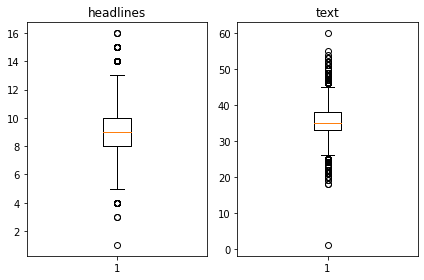

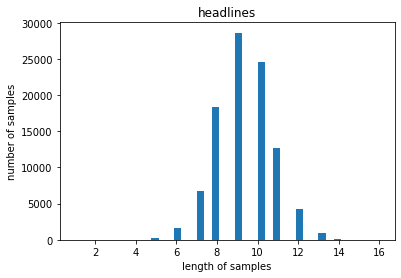

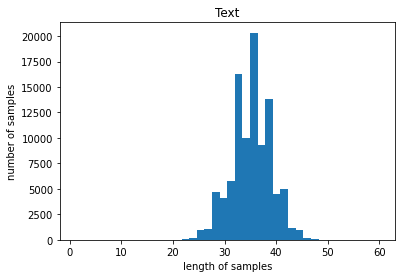

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 시각화 결과  
- text 경우  
  최소 1, 최대 60  
  평균 35

- headlines 경우  
  최소 1, 최대 16  
  평균 9

#### 2. Text의 최대 길이와 Summary의 적절한 최대 길이 정하기  

##### 1) 임의로 정해보기

In [18]:
text_max_len = 45
headlines_max_len = 12
print('=3')

=3


In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


##### 2) 객관적 길이 결정을 평가  
정한 최대 길이가 얼마나 많은 샘플 포함할수 있는지 확인하기 위해 함수 생성 

In [21]:
# 맥스 길이보다 길면 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


#### 3. 시작 토큰 - 종료 토큰 추가하기
* 시작 토큰은 sostoken,  
  종료 토큰은 eostoken이라  
  임의로 명명하고 앞, 뒤로 추가  


* decoder_input : 디코더의 입력, 시작 토큰이 맨 앞에 있는 문장의 이름   
  decoder_target : 디코더의 출력 또는 레이블, 종료 토큰이 맨 뒤에 붙는 문장의 이름
  두 개의 문장 모두 Summary 열로부터 만들 거예요

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

#앞,뒤로 토큰이 잘 붙어있음

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


#### 4. 인코더/디코더 입력 값, 디코더 레이블 다시 넘파이 타입으로 저장  
Summury 데이터의 인코더, 디코더임

In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 5. 훈련, 테스트 데이터 분리

##### 1) 순서가 잘 섞인 샘플 얻기

In [24]:
#인코더 인풋과 크기,형태 같고 
indices = np.arange(encoder_input.shape[0])
# 순서가 섞인 정수 시퀀스 생성
np.random.shuffle(indices)
print(indices)

#정수 시퀀스 통해 -> 데이터 샘플 순서 정의 -> 샘플 잘 섞여짐
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[17062 42681 68447 ... 41948 90933 56582]


#### 2) 8:2 비율로 훈련,테스트 분리하기

In [25]:
# 테스트 데이터 개수 구하기  

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


In [26]:
#테스트 데이터 개수 이용해서 전체 데이터 모두 분리하기

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


### 4. 정수 인코딩 

#### 1. encoder_input_ 단어 집합(vocabulary) 만들기 및 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련, 테스트 데이터 단어들  
모두 정수로 바꿔줘야함  
-> 해당 과정 : 단어 집합(vocabulary) 

In [27]:
#keras의 토크나이저 정의
#-> 원-핫인코딩 (각 항목을 벡터차원으로, 1 or0)을 간단히 변환가능
#-> 훈련 데이터로 부터 단어집합 생성 가능
src_tokenizer = Tokenizer() 

#입력된 데이터로부터 단어 집합 생성
#각 단어에 고유한 정수가 부여됨
# 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장

#fit_on_texts()  : 문자 데이터 입력 받아서 리스트 형태로 반환
#토크 나이저의 word_index : 단어와 숫자의 키-값을 포함하는 딕셔너리 반환
src_tokenizer.fit_on_texts(encoder_input_train) 

#### 2.encoder_input_ 등장 빈도수 낮은 데이터 제외하기
* 우리는 7회 미만은 버리려고함 

* src_tokenizer.word_counts.items()  
  단어와 각 단어의 등장 빈도수가 저장  
  통계적인 정보를 얻을 수 있음  

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69030
등장 빈도가 6번 이하인 희귀 단어의 수: 47030
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22000
단어 집합에서 희귀 단어의 비율: 68.12979863827321
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5190422700830446


encoder_input_train에는 6.9만 여개 단어 존재  

등장 빈도 7회 미만 단어  
단어 집합에서 무려 68% 이상  
그러나 훈련 데이터에서 7회 미만 단어 등장 빈도 비율 3.5%  
-> 정수 인코딩 과정, 훈련 데이터에서 제거  

등장 빈도 7회 미만 제외 시, 단어 집합의 크기를 8천여 개로 계산  
-> 단어 집합의 크기를 67000으로 제한  
-> 토크 나이저에서 num_words = 67000

#### 3. encoder_input 등장 빈도 수 낮은 데이터 버리고 새롭게 정수 인코딩

##### 3-1) encoder 인풋 데이터_ 새로운 단어 집합 생성(7회 미만 버리고 + 20000개 까지)

In [ ]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

##### 3-2) encoder 인풋 데이터_ 정수 인코딩

In [30]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
#texts_to_sequences(): 생성된 단어집합 기반해서, 입력으로 들어온 텍스트 데이터  
# 모두 정수로 변환하는 정수 인코딩 수행
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])
#단어 모두 정수로 바뀌어서 출력되고 있음 확인

[[79, 2796, 3903, 352, 154, 153, 108, 1084, 7810, 572, 253, 1062, 656, 1109, 154, 3821, 572, 3933, 1666, 565, 342, 2642, 2796, 3662, 4267, 221, 856, 214, 1917, 656, 177, 15, 9203], [69, 8730, 565, 6079, 29, 213, 927, 3369, 4453, 1, 1045, 67, 565, 565, 6079, 4453, 1, 2517, 851, 27, 15220, 12511, 125, 573, 2235, 6271, 1045, 182, 1045, 3446, 1281, 2517, 3446, 2844], [5, 16, 124, 40, 2399, 150, 513, 90, 989, 1385, 404, 1420, 37, 370, 3162, 136, 513, 16, 1031, 4630, 40, 370, 59, 1385, 404, 1, 150, 234, 236, 921, 4326, 438, 484, 5, 116, 5, 12886, 10191, 1425, 402, 2376]]


#### 4.  Summury 데이터_ 단어 집합(vocabulary) 만들기 및 정수 인코딩  
단어집합 생성되면서, 각 단어 고유 정수가 부여  
-> tar_tokenizer.word_index : 각 정수 저장됨  
-> tar_tokenizer.word_counts.items() : 단어, 각 단어 등장 빈도 수 저장

In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

#### 5. Summury 데이터_등장 빈도수 낮은 데이터 제외하기

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29912
등장 빈도가 5번 이하인 희귀 단어의 수: 19561
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10351
단어 집합에서 희귀 단어의 비율: 65.39515913345815
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.716484788984128


* 등장 빈도가 5회 이하인 단어  
  -> 단어 집합에서 65%를 차지  
  -> 실제로 훈련 데이터에서 등장 빈도로 차지하는 비율 4.7%  
  -> 이 단어들은 모두 제거

* 어림잡아 28600을 단어 집합의 크기로 제한

#### 6. Summury_빈 데이터 제거
* 전체 데이터에서 빈도수가 낮은 단어가 삭제  
  = 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 **빈(empty) 샘플**이 됨    


* 원문(text)에선 길어서 문제가 안됨  
  근데 **평균 길이가 4인 요약문(headlines)** 의 경우에는  
  이 현상이 굉장히 두드러질 가능성 높음  


* 요약문에서 길이=0이 된 샘플 인덱스 확인  
  -> 요약문의 길이가 1인 경우의 인덱스  
     각각 drop_train과 drop_test에 라는 변수에 저장  
  -> 이 샘플들은 모두 삭제할 거예요  


* 주의점  
  요약문인 decoder_input에는 sostoken , decoder_target에는 eostoken이 추가된 상태  
  -> 이 두 토큰은 모든 샘플에서 등장  
  -> 빈도수 높음  
  -> 단어 집합 제한에도 삭제되지 않았음  
  -> 길이가 0이 된 요약문 실제 길이 1로 나옴 (토큰만 남아서)

In [33]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 7617, 6783, 1486, 7, 7175, 864, 13, 278], [1, 1190, 166, 278, 4477, 2464, 4, 202, 2248], [1, 729, 28, 1545, 637, 1004, 170, 9, 1101, 20, 461], [1, 3967, 94, 2603, 1312, 1580, 16, 20, 470, 2132], [1, 7176, 792, 49, 842, 6, 901, 16, 2178]]
target
decoder  [[7617, 6783, 1486, 7, 7175, 864, 13, 278, 2], [1190, 166, 278, 4477, 2464, 4, 202, 2248, 2], [729, 28, 1545, 637, 1004, 170, 9, 1101, 20, 461, 2], [3967, 94, 2603, 1312, 1580, 16, 20, 470, 2132, 2], [7176, 792, 49, 842, 6, 901, 16, 2178, 2]]


In [34]:
#문장 길이 0인 문장들의 인덱스 찾아오기
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

#위에서 찾은 0인 문장의 인덱스들 제거하기
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

#길이 0 인 문장들 제거 후 개수
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 77496
훈련 레이블의 개수 : 77496
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


#### 7. 패딩하기
텍스트 시퀀스를 -> 정수 시퀀스로 변환함  
이제 샘플들 병렬처리를 위해  
문장 길이들을 같은 길이로 맞춰 줘야함  

이때 최대길이 사용해서 길이 맞춰줌  
최대 길이보다 짧으면 뒷 공간에 숫자 0 을 넣어줌  

In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### 5. 모델 설계하기  
함수형 API를 이용해서 인코더 설계

#### 1. 인코더 모델 설계

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
 #히든 스테이트 사이즈 : LSTM 에서는 얼만큼의 수용력을 가질지 정하는 파라미터
 # LSTM의 용량 크기, 뉴런 개수들에 해당됨
 #크다고 무조건 성능 개선 되는 것 아님 
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

  #LSTM 레이어 3개
  # 히든 스테이트 사이즈 늘리는 것 : LSTM 1개의 용량을 늘리는 것 
  # 레이어를 늘리는 것 : 모델의 용량을 늘리는 것

# 인코더의 LSTM 1
#dropout : 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결
#recurrent dropout : LSTM이 추가적으로 사용,  time step의 입력을 랜덤으로 생략
# 그냥 드롭아웃 처럼 regularization을 해주는 효과가 있고, 과적합을 방지
# 이렇게 두 드롭아웃 다 쓴것 : Variational Dropout
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줌 !

#경고문 : recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 
#recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸립니다.

#### 2. 디코더 모델 설계

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# 디코더 LSTM 입력 정의시, initial_state의 인자값으로 
#인코더의 hidden state와 cell state의 값 넣어줌
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#### 3. 어텐션 메커니즘  
이미 구현된 어텐션 함수 가져와서 디코더 출력층에 결합

인코더의 hidden state들 ,  디코더의 hidden state들을  
어텐션 함수의 입력으로 사용  
-> 어텐션 함수가 리턴한 값을  
예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

In [38]:
#경로에 attention.py 파일 생성 -> 어텐션 메커니즘 사용 준비 완료
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 6. 모델 훈련

#### 1. 모델 훈련

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#조기 종료: EarlyStopping : 특정 조건이 충족되면 훈련을 멈추는 역할 =모델 훈련 최적점에서 멈추기 가능
#monitor= : val_loss(검증 데이터의 손실)을 관찰
#patience : 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2)  
#관측되면 학습을 멈추도록 설정
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)    
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=25)

Epoch 1/25
303/303 [==============================] - 242s 763ms/step - loss: 5.8127 - val_loss: 5.0393
Epoch 2/25
303/303 [==============================] - 230s 759ms/step - loss: 4.9703 - val_loss: 4.6495
Epoch 3/25
303/303 [==============================] - 230s 759ms/step - loss: 4.5877 - val_loss: 4.3941
Epoch 4/25
303/303 [==============================] - 231s 761ms/step - loss: 4.3056 - val_loss: 4.1955
Epoch 5/25
303/303 [==============================] - 232s 765ms/step - loss: 4.0878 - val_loss: 4.0411
Epoch 6/25
303/303 [==============================] - 230s 759ms/step - loss: 3.9093 - val_loss: 3.9299
Epoch 7/25
303/303 [==============================] - 231s 764ms/step - loss: 3.7563 - val_loss: 3.8330
Epoch 8/25
303/303 [==============================] - 232s 765ms/step - loss: 3.6200 - val_loss: 3.7600
Epoch 9/25
303/303 [==============================] - 234s 771ms/step - loss: 3.4954 - val_loss: 3.6930
Epoch 10/25
303/303 [==============================] - 236s 778m

#### 2. 모델 훈련 과정 시각화  
훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정

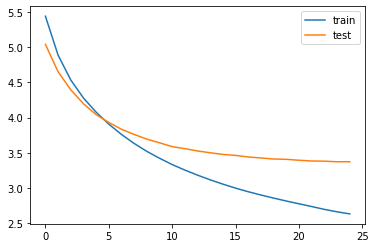

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 7. 인퍼런스 모델 구현  
* seq2seq는 훈련할 때, 실제 동작할 때(인퍼런스 단계)의 방식 다름  
  -> 그에 맞게 **모델 설계를 별개 진행**
  
  
* **훈련 단계**  
  디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고  
  디코더의 출력과 한 번에 비교 가능  
  인코더와 디코더를 엮은 통짜 모델 하나만 준비했었음  
  
  
* 그러나 정답 문장이 없는 **인퍼런스 단계**  
  만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야함  
  -> 인퍼런스를 위한 모델 설계 따로 해줌  
  -> 이때는 인코더 모델과 디코더 모델을 분리해서 설계

In [42]:
# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word 

# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index 

# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word 

#### 1. 인퍼런스 모델의_인코더 /디코더 설계

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서
#초기 상태(initial_state)를 이전 시점의 상태로 사용.
#이는 뒤의 함수 decode_sequence()에 구현

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태=state_h와
# 셀 상태인= state_c를 버리지 않음 (이전 상태에서 계속 가져옴)
# 훈련 과정에서는 그냥 초기 인코더 꺼 가져와서 초기화해버림
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#### 2. 인퍼런스 단계 _ 출력층 설계 (어텐션 매커니즘 사용)

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

#### 3. 인퍼런스 단계_ 단어 시퀀스 완성해주는 함수 생성

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 8. 모델 테스트 하기  

정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인  

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 생성해보자  
text 정수 시퀀스 -> 패딩을 위해 사용되는 숫자 0 제외  
headlines 정수 시퀀스 -> 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외

#### 1. 정수-> 텍스트 시퀀스 변환 함수 생성

In [46]:
# 원문(text)의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문(headlines)의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

#### 2. 테스트 데이터 약 50개의 샘플의 실제 요약 vs 예측된 요약

In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : year old delhi woman delivered premature baby car tuesday returned hospital allegedly finding doctor emergency section hospital authorities however said fault security guard inform family doctor present mother baby danger 
실제 요약 : delhi woman delivers baby in car after being denied doctor 
예측 요약 :  woman gives birth to baby in delhi


원문 : spot fine imposed people found defecating open maharashtra according rules framed state government fine imposed levied spitting public moreover anyone found urinating public attract fine 
실제 요약 : open defecation in maharashtra to invite fine 
예측 요약 :  fine fined for water in maharashtra


원문 : denying rumours third instalment film gangs anurag kashyap shared report tweeted true earlier writer filmmaker confirmed third film gangs film franchise planned part called part 
실제 요약 : not true anurag denies rumours of of 
예측 요약 :  anurag denies reports of housefull


원문 : twenty eight time german first division champions bayern munich scored goals minut

예측 요약 :  bengaluru based startup raises funds


원문 : couple travelled kilometres across us canada square foot house wheels forty two year old christian parsons year old alexis stephens sold set journey nearly three years ago house features bedroom son kitchen bathroom small chairs 
실제 요약 : us couple travels over km in house on wheels 
예측 요약 :  couple flies km to save km in china


원문 : boxer mary kom thursday defeated north korea kim mi semi finals kg event reach final world women boxing championships seventh time kom take ukraine final saturday year old previously five gold medals one silver medal tournament 
실제 요약 : mary kom reaches world boxing championships final for th time 
예측 요약 :  mary kom assured of world medal at asian games semis


원문 : road accident victim died ambulance driver allegedly left almost upside outside hospital several minutes kerala palakkad driver reportedly left injured man position urinating defecating inside vehicle accused charged endangering life criminal

예측 요약 :  david warner plays with his first match in england


원문 : pakistan army shot indian spy along line control pakistan army spokesperson major general asif claimed tuesday shot bagh sector along loc added director general inter services public relations released picture official twitter handle 
실제 요약 : pakistan claims it shot down indian spy 
예측 요약 :  pakistan isi of india to pak


원문 : former agent us intelligence agency cia charged conspiring spy chinese government department justice said jerry lee accused retaining classified documents revealing details cia assets undercover operatives china year old worked cia 
실제 요약 : former cia agent charged with spying for china 
예측 요약 :  fbi agent used to cia agent in china


원문 : former england manchester united captain david beckham revealed talk show heartbreaking none three sons play football despite talented year old also revealed six year old daughter harper plays sport gets watching play sport harper beckham said 
실제 요약 : that my s

* 결과분석  
1) 기존의 요약과는 다른 요약 + 원문의 내용을 담고 있는 의미 있는 요약되고 있음    
2) 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약함  
3) 그다지 좋지 않은 요약의 예도 꽤나 보이기도 함  


* 성능 개선 방안  
1) seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법  
2) 빔 서치(beam search)  
3) 사전 훈련된 워드 임베딩(pre-trained word embedding)  
4) 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)  

### 9. 추출적 요약 해보기

* 추상적 요약 -> 앞서 seq2seq로 한것  
  추출적 요약 -> 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약
  

* 패키지 Summa->  추출적 요약을 위한 모듈인 summarize를 제공

#### 1. 패키지 설치
클라우드의 경우 이미 summa 가 설치됨  

In [48]:
! pip list | grep summa

summa                         1.2.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


#### 2. 데이터 다운로드하기

In [49]:
import requests
from summa.summarizer import summarize

#### 3. 매트릭스 시놉시스를 다운로드  

In [50]:
#text = 매트릭스 시놉시스가 문자열로 저장  
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [51]:
#잘 저장이 되었는지 확인
#출력결과 너무 길어서 일부만 출력
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

#### 4. summarize 사용하기
* Summa의 summarize()의 인자로 사용되는 값  
  1) text (str) : 요약할 테스트  
  2) ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
  3) words (int or None, optional) – 출력에 포함할 단어 수  
     만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시  
  4) split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환  

Summa의 summarize는 문장 토큰화 안해도  
-> 내부적으로 문장 토큰화를 수행  
-> 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣어도 됨  

비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄임  
원문의 0.005%만을 출력하도록 설정함  

In [52]:
print('headlines:')
print(summarize(text, ratio=0.005))

headlines:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [53]:
print('headlines:')
# split=True : 출력 결과 리스트로
print(summarize(text, ratio=0.005, split=True))

headlines:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [54]:
print('headlines:')
#단어 수 : 요약문 크기 조절 가능
print(summarize(text, words=50))

headlines:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


### 10. 추상적 요약 vs 추출적 요약  

- 추상적 요약보다 추출적 요약이 실제 요약과 더 비슷하게 요약된 것 으로 판단됨  .
- 추상적 요약에는 더 많은 데이터와 학습이 필요할 것 같음  

- 추출적 요약이 더 잘 요약된 이유는  
  키워드가 되는 단어를 그대로 사용했기 때문인 것 같음  

- 전처리할때 소문자로 모두 변환했었는데  
  추출적 요약시에 대문자로 출력됨  

### 회고  

#### 💚 루브릭  
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.  
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행됨  


2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.  
   1) 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인할 수 있었음  
      Earlystop 기능으로 적절한 에포크 횟수의 학습을 진행할 수 있었음  
      val loss를 약 3.3~3.4 까지 감소시켰음  
      (이전 학습에서는 3.8-7 정도가 평균으로 출력되었었음)

   2) 실제 요약문과 유사한 요약문장을 얻을 수 있었음  
      원문 : cement major chairman non executive director kumar mangalam birla received annual remuneration crore birla  
      remuneration saw increase previous financial year notably remuneration contrast lakh earned group telecom arm idea cellular  
      실제 요약 : kumar birla took crore salary from  
      예측 요약 :  aditya birla chairman singh earned crore in  

      원문 : 독일 1부 리그 우승팀 바이에른 뮌헨이 시즌 전 지역 클럽 FC와 경기전 28분 동안 골을 넣었고,  
      많은 다른 선수들이 4골을 넣으며 해트트릭을 성공시켰고, 바이에른은 전반전에 7골을 넣었다.  
      실제요약: 팀 득점 시간: 선수 네트 해트트릭  
      예측요약: 뭄바이리그 해트트릭 득점  


3. Extractive 요약을 시도해 보고 Abstractive 요약 결과 비교하기  
Extractive 방식으로 추출된 요약문이 Abstractive 요약 결과 보다  
문법완성도, 핵심단어 포함 측면에서 괜찮은 요약을 보여주는 것 같음  


#### 💚 어려웠던 점  
- 요약이 잘된지, 안된건지 판단하기가 어려웠음  
- 처음에 단어사전의 크기를 어떻게 설정할지 조금 판단하기 어려웠었음  

#### 💚 재밌었던 점  
- 어텐션 메커니즘을 직접 써볼 수 있었던 경험이 재밌었음  
- 뉴스 요약을 위한 데이터 구축을 위한 아르바이트 공고를 본적이 있는데  
  몇일 안되어서 해당 노드를 보니까 피부로 느끼는 기술이라 재밌게 느껴짐  
  
#### 💚 개선 및 노력하고 싶은 점  
- 해당 노드에서는 어텐션 메커니즘이 적용된 모델을 사용해보기만 해봄  
  이번주에 어텐션 논문 읽고 다음주 월욜에 리뷰를 하기로 했는데  
  해당 논문을 읽고 깊이 좀 이해하고 싶음  